In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.interpolate
from astropy.time import Time, TimeDelta
import astropy.constants
import multiprocessing
import datetime
import itertools
import functools
import os.path

c = astropy.constants.c.value

In [2]:
fs = 40000

In [3]:
lowpass = scipy.signal.firwin(1024, 10e-3)

In [4]:
N = 2**16
pwr_avg = 2**14
noncoherent_time = 10
chunk_length = noncoherent_time + 2 # leave 1 second before and 1 second after
doppler_span_hz = 50
freq_step = 0.25
freqs = np.arange(-doppler_span_hz, doppler_span_hz, freq_step)

In [5]:
def do_ffts(path, start_sample, num_ffts, cs_direct, cs_moonbounce, pwr_sum = pwr_avg):
    first_sample = start_sample - lowpass.size
    nsamples = num_ffts * N + lowpass.size
    with open(path, 'rb') as f:
        f.seek(first_sample * 8)
        x = np.fromfile(f, dtype = np.complex64, count = nsamples)
        
    if x.size < nsamples:
        raise ValueError
    
    direct_freq = cs_direct(np.arange(x.size) + first_sample)
    moonbounce_freq = cs_moonbounce(np.arange(x.size) + first_sample)
    direct_lo = np.exp(-1j*2*np.pi*np.cumsum(direct_freq)/fs)
    moonbounce_lo = np.exp(-1j*2*np.pi*np.cumsum(moonbounce_freq)/fs)
    
    x_direct = scipy.signal.lfilter(lowpass, 1, x * direct_lo)[lowpass.size:]
    x_moonbounce = scipy.signal.lfilter(lowpass, 1, x * moonbounce_lo)[lowpass.size:]
    
    pwr_direct = np.sum(np.abs(x_direct.reshape((-1,pwr_sum)))**2, axis = 1)
    pwr_moonbounce = np.sum(np.abs(x_moonbounce.reshape((-1,pwr_sum)))**2, axis = 1)
    
    # we use a flattop window to improve the response in the frequency domain
    # we also do overlapping FFTs
    w = scipy.signal.flattop(N)
    k = num_ffts
    moonbounce_ffts_conj = np.conj(np.fft.fft(np.concatenate((x_moonbounce[:N*k],x_moonbounce[N//2:N*k-N//2])).reshape(2*k-1,N) * w, axis = 1))
    corr_timefreq = np.empty((2*k-1, 1200, freqs.size))
    for j, freq in enumerate(freqs):
        shifted_direct_ffts = np.fft.fft(np.concatenate((x_direct[:N*k],x_direct[N//2:N*k-N//2])).reshape(2*k-1,N) * np.exp(1j*2*np.pi*np.arange(N)*freq/fs) * w, axis = 1)
        corr = np.abs(np.fft.ifft(shifted_direct_ffts * moonbounce_ffts_conj, axis = 1))**2
        corr = np.concatenate((corr[:,-600:], corr[:,:600]), axis = 1)[:,::-1]
        corr_timefreq[::2,:,j] = corr[:k,:]
        corr_timefreq[1::2,:,j] = corr[k:,:]
    
    return corr_timefreq, pwr_direct, pwr_moonbounce

In [6]:
def do_power(path, start_sample, num_ffts, cs_direct, cs_moonbounce):
    first_sample = start_sample - lowpass.size
    nsamples = num_ffts * N + lowpass.size
    with open(path, 'rb') as f:
        f.seek(first_sample * 8)
        x = np.fromfile(f, dtype = np.complex64, count = nsamples)
        
    if x.size < nsamples:
        raise ValueError
    
    direct_freq = cs_direct(np.arange(x.size) + first_sample)
    moonbounce_freq = cs_moonbounce(np.arange(x.size) + first_sample)
    direct_lo = np.exp(-1j*2*np.pi*np.cumsum(direct_freq)/fs)
    moonbounce_lo = np.exp(-1j*2*np.pi*np.cumsum(moonbounce_freq)/fs)
    
    x_direct = scipy.signal.lfilter(lowpass, 1, x * direct_lo)[lowpass.size:]
    x_moonbounce = scipy.signal.lfilter(lowpass, 1, x * moonbounce_lo)[lowpass.size:]
     
    pwr_sum = 2**14
    pwr_direct = np.sum(np.abs(x_direct.reshape((-1,pwr_sum)))**2, axis = 1)
    pwr_moonbounce = np.sum(np.abs(x_moonbounce.reshape((-1,pwr_sum)))**2, axis = 1)
    
    return pwr_direct, pwr_moonbounce

In [7]:
def process_block(j, path, num_ffts, fft_output_name, first_sample, css):
    print('Block', j, datetime.datetime.now())
    corr, p1, p2 = do_ffts(path, first_sample + j * N * num_ffts, num_ffts, css[0], css[1])
    np.save(f'sme_timefreq/{fft_output_name}_{j:04}.npy', corr)
    np.save(f'sme_timefreq/{fft_output_name}_p1_{j:04}.npy', p1)
    np.save(f'sme_timefreq/{fft_output_name}_p2_{j:04}.npy', p2)

In [8]:
def process_file(path, recording_start, start_time, end_time, fft_output_name, freq_offset = -750, num_ffts = 25, do_blocks = None):
    doppler_data = np.load('sme_doppler.npz')
    direct_sample = np.array([(t - recording_start).sec * fs for t in doppler_data['direct_t']])
    moonbounce_sample = np.array([(t - recording_start).sec * fs for t in doppler_data['moonbounce_t']])
    cs_direct = scipy.interpolate.CubicSpline(direct_sample, doppler_data['direct_doppler'] - freq_offset)
    cs_moonbounce = scipy.interpolate.CubicSpline(moonbounce_sample, doppler_data['moonbounce_doppler'] - freq_offset)
     
    first_sample = int((start_time - recording_start).sec * fs)
    num_samples = int((end_time - start_time).sec * fs)
    num_blocks = num_samples // (N * num_ffts)
    
    proc = functools.partial(process_block, path = path,\
                             num_ffts = num_ffts, fft_output_name = fft_output_name,\
                             first_sample = first_sample,\
                             css = (cs_direct, cs_moonbounce))
    with multiprocessing.Pool(4) as p:
        p.map(proc, range(num_blocks) if do_blocks is None else do_blocks)

In [9]:
def generate_images(fft_output_name, png_output_name, num_blocks, averaging = 20, num_ffts = 25, vmin = 1e-10, vmax = 4e-10):
    ffts_per_block = 2 * num_ffts - 1
    total_ffts = num_blocks * ffts_per_block
    w = scipy.signal.windows.hann(averaging).reshape((averaging,1,1))
    block = -1
    frame = np.empty((1200, freqs.size))
    for j in range(total_ffts - averaging):
        if (block + 1) * ffts_per_block <= j:
            block = j // ffts_per_block
            print('Block', block)
            left = np.load(f'sme_timefreq/{fft_output_name}_{block:04}.npy')
            need_right = True
        s = j - block * ffts_per_block
        frame[...] = np.sum(left[s:s+averaging,...] * w[:ffts_per_block-s], axis = 0)
        if s + averaging > ffts_per_block:
            if need_right:
                right = np.load(f'sme_timefreq/{fft_output_name}_{block+1:04}.npy')
                need_right = False
            frame += np.sum(right[:s+averaging-ffts_per_block,...] * w[ffts_per_block-s:], axis = 0)
        plt.imsave(f'sme_timefreq/{png_output_name}_{j:004}.png', frame[:,::-1].T, vmin = vmin, vmax = vmax)

In [26]:
def plot_total_frame(fft_output_name, num_blocks, num_ffts = 25, vmin = 0.7e-8, vmax = 2.5e-8):
    total_frame = np.zeros((1200, freqs.size))
    for j in range(num_blocks):
        total_frame += np.sum(np.load(f'sme_timefreq/{fft_output_name}_{j:04}.npy'), axis = 0)
    plt.figure(figsize = [15,8], facecolor='w')
    plt.imshow(total_frame.T, vmin = vmin, vmax = vmax, aspect = 'auto', extent = [-600 / fs * c * 1e-3, 600 / fs * c * 1e-3, -50, 50])
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Delay (km)')
    plt.title('Correlation (averaged over all the transmission)');
    return total_frame

In [11]:
def plot_power(fft_output_name, num_blocks, start):
    plt.figure(figsize = [15,8], facecolor='w')
    p1 = np.concatenate([np.load(f'sme_timefreq/{fft_output_name}_p1_{j:04}.npy') for j in range(num_blocks)])
    p2 = np.concatenate([np.load(f'sme_timefreq/{fft_output_name}_p2_{j:04}.npy') for j in range(num_blocks)])
    t = start + TimeDelta(np.arange(p1.size) * pwr_avg / fs, format='sec')
    plt.plot(t.datetime, 10*np.log10(p1))
    plt.plot(t.datetime, 10*np.log10(p2))
    plt.title('Power')
    plt.xlabel('UTC time')
    plt.ylabel('Power (dB)')
    plt.legend(['Direct', 'Moonbounce'])

In [12]:
path = '/home/daniel/Descargas/DSLWP-B_PI9CAM_2018-10-07T10_37_18_436.4MHz_40ksps_complex.raw'
recording_start = Time('2018-10-07T10:37:18')
start = Time('2018-10-07T11:17:00')
end = Time('2018-10-07T11:30:30')

In [13]:
process_file(path, recording_start, start, end, 'fft')

Block 2 2018-10-14 22:06:52.746316
Block 4 2018-10-14 22:06:52.747214
Block 0 2018-10-14 22:06:52.746168
Block 6 2018-10-14 22:06:52.750394
Block 5 2018-10-14 22:14:15.077304
Block 3 2018-10-14 22:14:15.777889
Block 7 2018-10-14 22:14:27.051548
Block 1 2018-10-14 22:14:37.381367
Block 8 2018-10-14 22:21:50.512921
Block 10 2018-10-14 22:22:00.546816
Block 12 2018-10-14 22:22:00.605109
Block 14 2018-10-14 22:22:18.431953
Block 9 2018-10-14 22:29:47.711545
Block 13 2018-10-14 22:29:57.195401
Block 11 2018-10-14 22:30:02.337345
Block 15 2018-10-14 22:30:22.023368
Block 16 2018-10-14 22:37:47.424991
Block 18 2018-10-14 22:37:53.851313
Block 17 2018-10-14 22:42:10.170791


In [14]:
generate_images('fft', 'img', 19)

Block 0
Block 1
Block 2
Block 3
Block 4
Block 5
Block 6
Block 7
Block 8
Block 9
Block 10
Block 11
Block 12
Block 13
Block 14
Block 15
Block 16
Block 17
Block 18


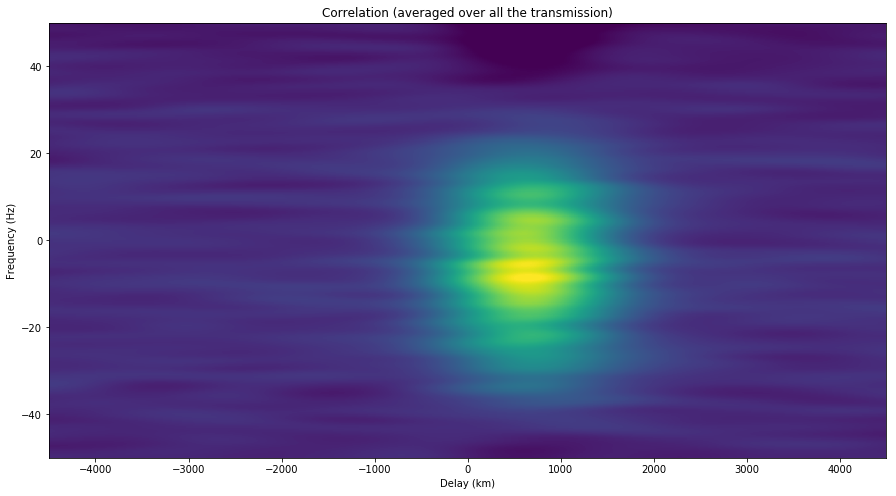

In [27]:
totframe = plot_total_frame('fft', 19)

In [16]:
path2 = '/home/daniel/Descargas/DSLWP-B_PI9CAM_2018-10-07T11_30_45_436.4MHz_40ksps_complex.raw'
recording_start2 = Time('2018-10-07T11:30:45')
start2 = Time('2018-10-07T11:38:00')
end2 = Time('2018-10-07T11:51:00')

In [17]:
process_file(path2, recording_start2, start2, end2, 'fft2')

Block 4 2018-10-14 22:48:00.606331
Block 2 2018-10-14 22:48:00.605813
Block 0 2018-10-14 22:48:00.605805
Block 6 2018-10-14 22:48:00.606686
Block 1 2018-10-14 22:56:02.817923
Block 5 2018-10-14 22:56:05.681244
Block 3 2018-10-14 22:56:13.000492
Block 7 2018-10-14 22:56:15.307592
Block 8 2018-10-14 23:03:58.369870
Block 10 2018-10-14 23:04:05.990570
Block 12 2018-10-14 23:04:30.258570
Block 14 2018-10-14 23:04:30.259491
Block 9 2018-10-14 23:11:42.290710
Block 11 2018-10-14 23:12:28.417405
Block 15 2018-10-14 23:13:07.851132
Block 13 2018-10-14 23:13:16.075284
Block 16 2018-10-14 23:20:12.609847
Block 18 2018-10-14 23:20:41.021968
Block 17 2018-10-14 23:25:26.535518


In [18]:
generate_images('fft2', 'img2', 19)

Block 0
Block 1
Block 2
Block 3
Block 4
Block 5
Block 6
Block 7
Block 8
Block 9
Block 10
Block 11
Block 12
Block 13
Block 14
Block 15
Block 16
Block 17
Block 18


Run the following to generate the videos
```
ffmpeg -framerate 12 -i img_%04d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p output.mp4
ffmpeg -framerate 12 -i img2_%04d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p output2.mp4
```

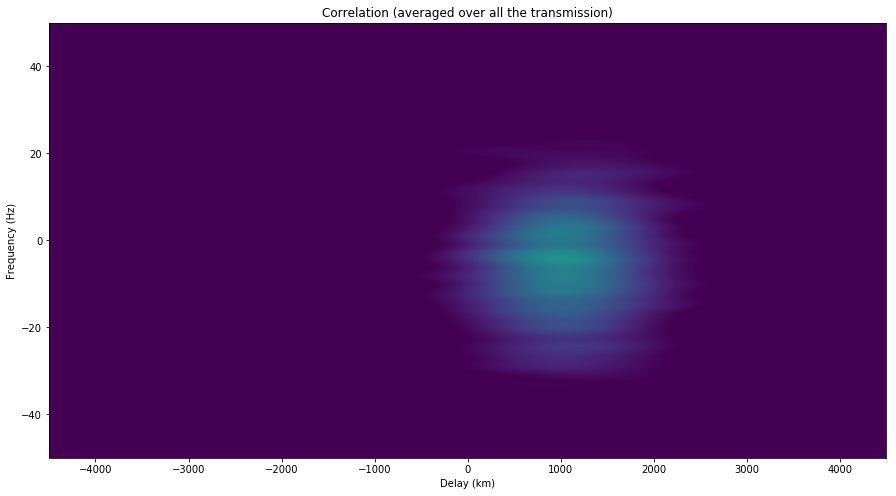

In [28]:
totframe2 = plot_total_frame('fft2', 19)

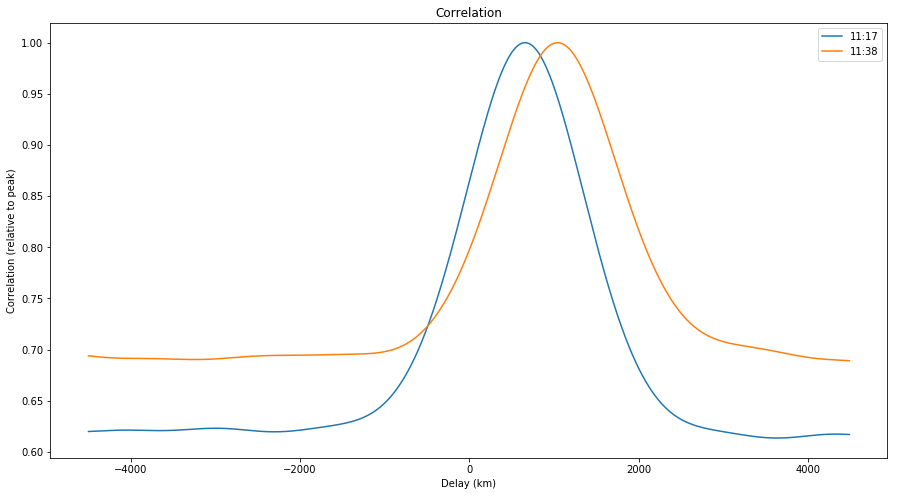

In [20]:
plt.figure(figsize = [15,8], facecolor='w')
totframe_time = np.sum(totframe, axis = 1)
totframe2_time = np.sum(totframe2, axis = 1)
x = np.arange(-600,600) / fs * c * 1e-3
plt.plot(x, totframe_time/np.max(totframe_time))
plt.plot(x, totframe2_time/np.max(totframe2_time))
plt.xlabel('Delay (km)')
plt.ylabel('Correlation (relative to peak)')
plt.legend(['11:17', '11:38'])
plt.title('Correlation');

In [21]:
x[np.argmax(totframe_time)]

659.54340760000002

In [22]:
x[np.argmax(totframe2_time)]

1041.7787915500001

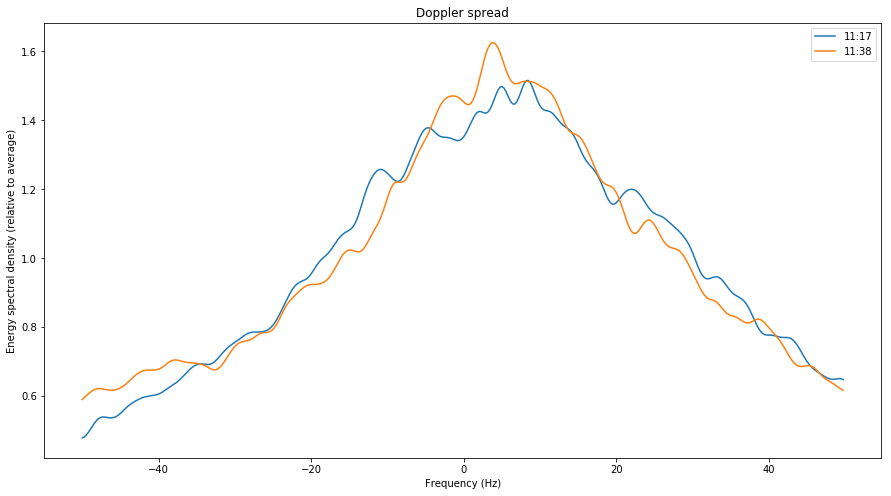

In [23]:
plt.figure(figsize = [15,8], facecolor='w')
totframe_freq = np.sum(totframe[600:900,:], axis = 0)
totframe2_freq = np.sum(totframe2[600:900,:], axis = 0)
x = np.arange(-doppler_span_hz, doppler_span_hz, freq_step)
plt.plot(x, totframe_freq/np.average(totframe_freq))
plt.plot(x, totframe2_freq/np.average(totframe2_freq))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy spectral density (relative to average)')
plt.legend(['11:17', '11:38'])
plt.title('Doppler spread');

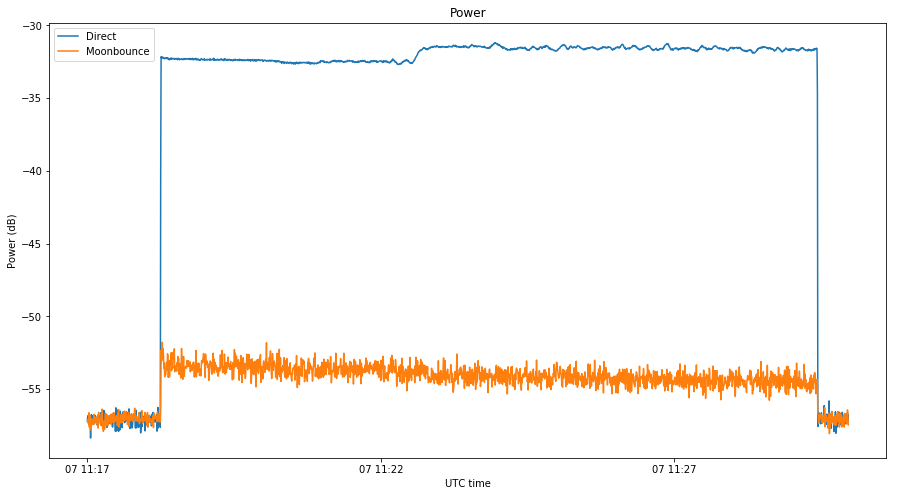

In [24]:
plot_power('fft', 19, start)

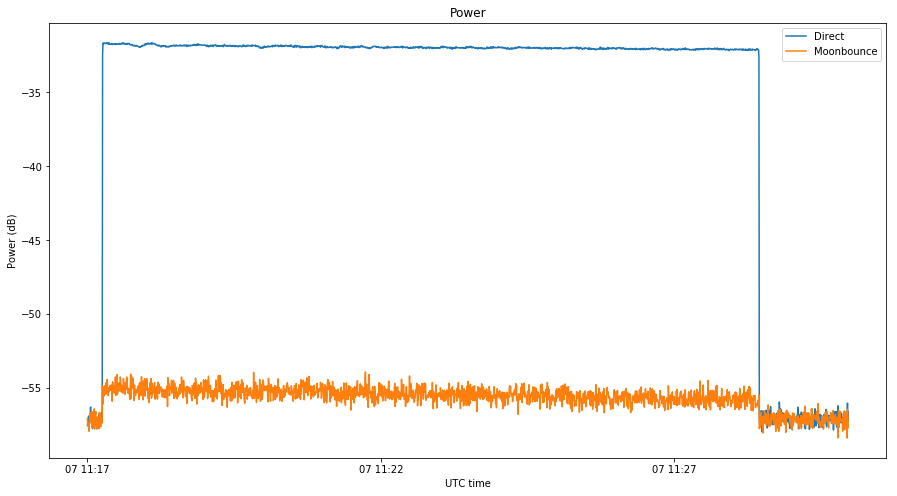

In [25]:
plot_power('fft2', 19, start)